# NLP Analysis of NFL Prospect Reports

In [20]:
# Basic Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import hugging face transformers
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from transformers import pipeline

In [21]:
# Create a DataFrame from the player_bios.csv file
df = pd.read_csv('player_bios.csv')

df

,Player Bio,Player Grades,Player,Link
0,A physical specimen with a rare size-speed com...,7.50,Jadeveon Clowney,https://www.nfl.com/prospects/jadeveon-clowney...
1,A legitimate No. 1-caliber receiver who steppe...,7.10,Sammy Watkins,https://www.nfl.com/prospects/sammy-watkins/32...
2,"A highly disruptive, athletic specimen with th...",7.00,Anthony Barr,https://www.nfl.com/prospects/anthony-barr/320...
3,A havoc-wreaking rush linebacker with the burs...,7.00,Khalil Mack,https://www.nfl.com/prospects/khalil-mack/3200...
4,"Smart, tough, versatile franchise left tackle ...",7.00,Jake Matthews,https://www.nfl.com/prospects/jake-matthews/32...
...,...,...,...,...
3964,Webb is a Florida product but helped Stevenson...,5.50,Jeremy Webb,https://www.nfl.com/prospects/jeremy-webb/3200...
3965,"Russ is the son of Craig Yeast, who was the SE...",5.50,Russ Yeast,https://www.nfl.com/prospects/russ-yeast/32005...
3966,"Marks was known as ""Grandpa"" on the field as a...",5.49,Ken Marks,https://www.nfl.com/prospects/ken-marks/32004d...
3967,Wynn was coached by former Georgia and NFL run...,5.46,Devin Wynn,https://www.nfl.com/prospects/devin-wynn/32005...


In [23]:
# Create a pipeline to analyze sentiment of player bios with a max length of 512 tokens
nlp = pipeline('sentiment-analysis', model='siebert/sentiment-roberta-large-english', max_length=512)

# Create a new column in the DataFrame to hold the sentiment analysis and confidence scores
df['sentiment'] = None
df['confidence'] = None

# Loop through the DataFrame and run the sentiment analysis on each player bio (~40 minutes on a CPU)
for index, row in df.iterrows():
    result = nlp(row['Player Bio'])
    df.at[index, 'sentiment'] = result[0]['label']
    df.at[index, 'confidence'] = result[0]['score']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [24]:
# Create a new column for adjusted confidence
df['adjusted_confidence'] = None

# If the sentiment is negative, subtract the confidence score from 1
for index, row in df.iterrows():
    if row['sentiment'] == 'NEGATIVE':
        df.at[index, 'adjusted_confidence'] = 1 - row['confidence']
    else:
        df.at[index, 'adjusted_confidence'] = row['confidence']

In [25]:
df

,Player Bio,Player Grades,Player,Link,sentiment,confidence,adjusted_confidence
0,A physical specimen with a rare size-speed com...,7.50,Jadeveon Clowney,https://www.nfl.com/prospects/jadeveon-clowney...,POSITIVE,0.998497,0.998497
1,A legitimate No. 1-caliber receiver who steppe...,7.10,Sammy Watkins,https://www.nfl.com/prospects/sammy-watkins/32...,POSITIVE,0.998784,0.998784
2,"A highly disruptive, athletic specimen with th...",7.00,Anthony Barr,https://www.nfl.com/prospects/anthony-barr/320...,POSITIVE,0.998658,0.998658
3,A havoc-wreaking rush linebacker with the burs...,7.00,Khalil Mack,https://www.nfl.com/prospects/khalil-mack/3200...,POSITIVE,0.99885,0.99885
4,"Smart, tough, versatile franchise left tackle ...",7.00,Jake Matthews,https://www.nfl.com/prospects/jake-matthews/32...,POSITIVE,0.998856,0.998856
...,...,...,...,...,...,...,...
3964,Webb is a Florida product but helped Stevenson...,5.50,Jeremy Webb,https://www.nfl.com/prospects/jeremy-webb/3200...,NEGATIVE,0.993244,0.006756
3965,"Russ is the son of Craig Yeast, who was the SE...",5.50,Russ Yeast,https://www.nfl.com/prospects/russ-yeast/32005...,POSITIVE,0.998128,0.998128
3966,"Marks was known as ""Grandpa"" on the field as a...",5.49,Ken Marks,https://www.nfl.com/prospects/ken-marks/32004d...,POSITIVE,0.997836,0.997836
3967,Wynn was coached by former Georgia and NFL run...,5.46,Devin Wynn,https://www.nfl.com/prospects/devin-wynn/32005...,POSITIVE,0.996665,0.996665


In [26]:
# Create a new column that holds a normal distribution of the player grades
df['grade_norm'] = (df['Player Grades'] - df['Player Grades'].mean()) / df['Player Grades'].std()

# Create a new column that holds a normal distribution of the adjusted confidence
df['confidence_norm'] = (df['adjusted_confidence'] - df['adjusted_confidence'].mean()) / df['adjusted_confidence'].std()

<Figure size 1000x600 with 0 Axes>

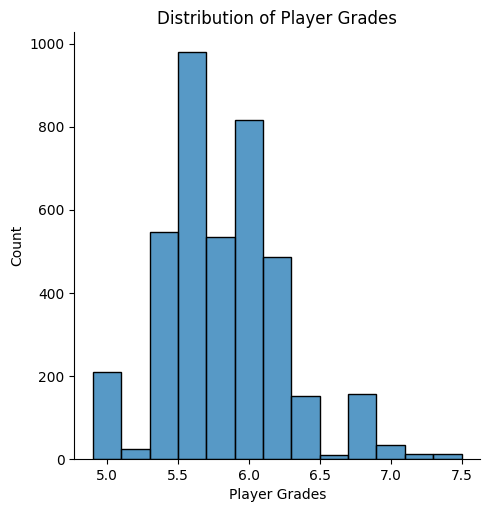

<Figure size 640x480 with 0 Axes>

In [35]:
# Create a bar chart to show the distribution of the grades

# 8 = the perfect prospect, 7.3-7.5 = Perennial All-Pro, 7.0-7.1 = Pro Bowl talent,
# 6.7-6.9 = Year 1 Starter, 6.5-6.6 = Boom-or-bust potential, 6.40-6.49 = Will become good starter within two years,
# 6.30-6.39 = Will eventually be plus starter, 6.20-6.29 = Will eventually be average started,
# 6.10-6.19 = Good back with potential to develop into starter, 6.00-6.09 = traits or talents to be above-average backup,
# 5.80-5.99 = average backup or special teamer, 5.60-5.69 = Candidate for bottom of roster or practice squad,
# 5.50-5.59 = Priority undrafted free agent

plt.figure(figsize=(10, 6))
sns.displot(df['Player Grades'], bins=13, kde=False)
plt.title('Distribution of Player Grades')
plt.xlabel('Player Grades')
plt.ylabel('Count')
plt.show()

# Save the bar chart to the images folder
plt.savefig('images/grade_distribution.png')

<Figure size 1000x600 with 0 Axes>

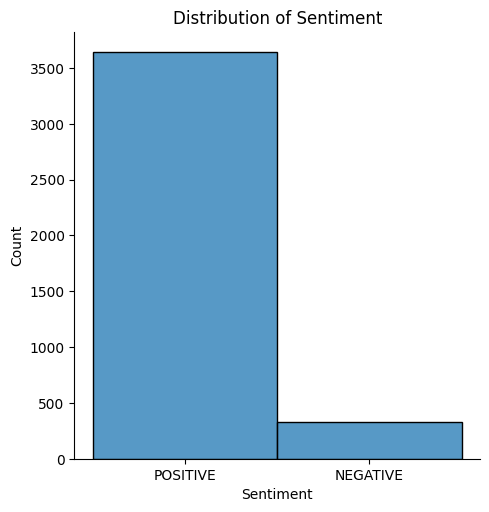

In [37]:
# Create a bar chart to show the distribution of positive and negative sentiment
plt.figure(figsize=(10, 6))
sns.displot(df['sentiment'], bins=2, kde=False)

# Set the title and axis labels
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Save the bar chart to the images folder
plt.savefig('images/sentiment_distribution.png')

<Figure size 1000x600 with 0 Axes>

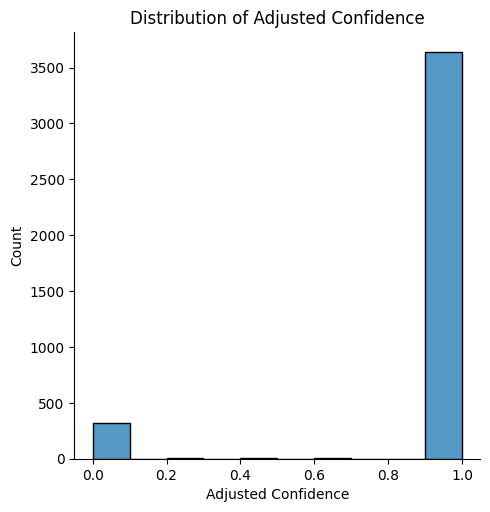

In [38]:
# Create a bar chart to show the distribution of the adjusted confidence
plt.figure(figsize=(10, 6))
sns.displot(df['adjusted_confidence'], bins=10, kde=False)

# Set the title and axis labels
plt.title('Distribution of Adjusted Confidence')
plt.xlabel('Adjusted Confidence')
plt.ylabel('Count')

# Save the bar chart to the images folder
plt.savefig('images/adjusted_confidence_distribution.png')